In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from astropy.table import Table
import astropy.units as u
from astropy.io import fits

import nfft
import scipy.signal as signal

In [2]:
plt.style.use('notebook')

## Read in a TESS light curve

In [3]:
tin = Table.read('../data/aguirre_1sec.fits')
i0 = 13

In [4]:
tin[i0]

TIC,HIP,numax,Stnumax,Synumax,Delnu,StDelNu,SyDelNu,Vmag,e_Vmag,Teff,e_Teff,[Fe/H],e_[Fe/H],R,StR,SyR,M,StM,SyM,Age,StAge,SyAge,Ref,fname
,,uHz,uHz,uHz,uHz,uHz,uHz,mag,mag,K,K,[Sun],[Sun],solRad,solRad,solRad,solMass,solMass,solMass,Gyr,Gyr,Gyr,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,bytes85
155940286,1766,73.2,1.3,0.32,7.4,0.02,0.11,6.81,0.01,4630.0,80.0,0.03,0.08,6.95,0.18,0.14,1.01,0.06,0.04,12.0,1.78,36.07,2016AJ....152...19W,../data/singletess_lightcurve/tess2018234235059-s0002-0000000155940286-0121-s_lc.fits


In [5]:
t = Table(fits.getdata(tin['fname'][i0], ignore_missing_end=True))

tm = t['TIME']
fm = t['PDCSAP_FLUX']
fm = fm - np.nanmean(fm)
ind_finite = np.isfinite(fm)
tm = tm[ind_finite]
fm = fm[ind_finite]
ivar = (t['PDCSAP_FLUX_ERR'][ind_finite])**-2

## Non-uniform FFT

In [6]:
# set up fine frequency grid
N = 600
eta = 0.01
N = int(N/eta)
k_iday = (-int(N/2) + np.arange(N))*eta
k = (k_iday*u.day**-1).to(u.uHz)

In [7]:
# calculate NFFT amplitudes
f_lc = nfft.nfft_adjoint(tm*eta, fm, len(k))
amp = np.sqrt(f_lc.real**2 + f_lc.imag**2)        

## Lomb-Scargle periodogram

In [8]:
ind_positive = k_iday>0
frlin = k_iday[ind_positive]
freq = frlin * 2*np.pi

In [23]:
pgram = signal.lombscargle(tm, fm, freq, normalize=False)

## Forward model

In [10]:
def ln_profile_like_K_freqs(ts, ys, yivars, nu, deltanu, K=3):
    """Likelihood for a comb of K frequencies centered on nu and separated by deltanu (solves for the amplitudes)"""
    
    assert len(ts) == len(ys)
    
    halfK = (K - 1) // 2
    thisK = 2 * halfK + 1
    A = np.zeros((len(ts), 2 * thisK + 1))
    
    for k in range(thisK):
        f = nu - halfK * deltanu + k * deltanu
        A[:, 2 * k]     = np.cos(2. * np.pi * f * ts)
        A[:, 2 * k + 1] = np.sin(2. * np.pi * f * ts)
    
    A[:, -1] = 1.
    resid = ys - np.dot(A, np.linalg.solve(np.dot(A.T * yivars, A), np.dot(A.T * yivars, ys)))
    
    return -0.5 * np.sum(yivars * resid ** 2)

In [65]:
# select only frequencies in the relevant range (to save on computation time)
ind_xrange = (k>50*u.uHz) & (k<100*u.uHz)
freqs = k[ind_xrange]
freqs_iday = k_iday[ind_xrange]

# solve for a variety of Delta nu
Ndfreq = 10
dfreqs = np.linspace(3,12.5,Ndfreq)*u.uHz
dfreqs = np.arange(3.5, 10.5, 1)*u.uHz
dfreqs_iday = dfreqs.to(u.day**-1).value

Ndfreq = np.size(dfreqs)

K0 = 3

In [66]:
fll = np.empty((Ndfreq, np.size(freqs)))
for i in range(Ndfreq):
    fll[i] = np.array([ln_profile_like_K_freqs(tm, fm, ivar, f, dfreqs_iday[i], K=K0) for f in freqs_iday])

## Frequency spectra

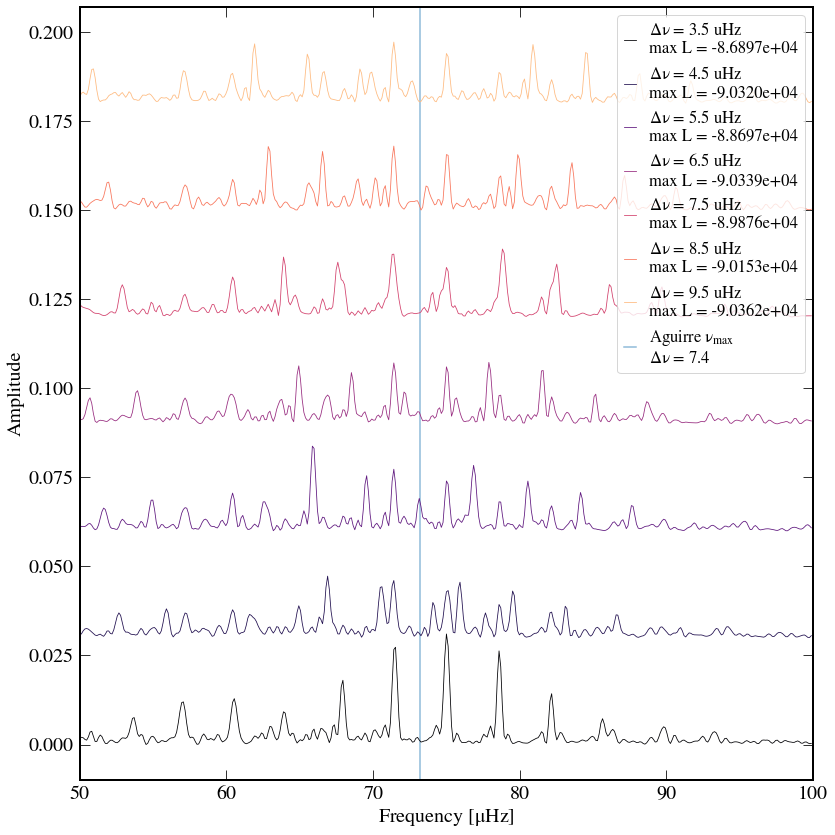

In [75]:
# compare forward models of the light curve assuming different Delta nu
cmap = mpl.cm.magma

plt.figure(figsize=(12,12))

for i in range(Ndfreq):
    plt.plot(k[ind_xrange], 0.03*i+(fll[i]-np.min(fll[i]))*4e-6, '-', color=cmap(i/Ndfreq), lw=0.8,
             label='$\Delta\\nu$ = {:.1f}\nmax L = {:.4e}'.format(dfreqs[i], np.max(fll[i])))
plt.axvline(tin['numax'][i0], label='Aguirre $\\nu_{{max}}$\n$\Delta\\nu$ = {:.1f}'.format(tin['Delnu'][i0]),
            zorder=0, alpha=0.5)

plt.legend(fontsize='small', handlelength=0.7)
plt.xlim(50,100)
# plt.ylim(0, 0.05)

plt.xlabel('Frequency [$\mu$Hz]')
plt.ylabel('Amplitude')

plt.tight_layout()

In [68]:
np.median(ivar)

0.0001047554

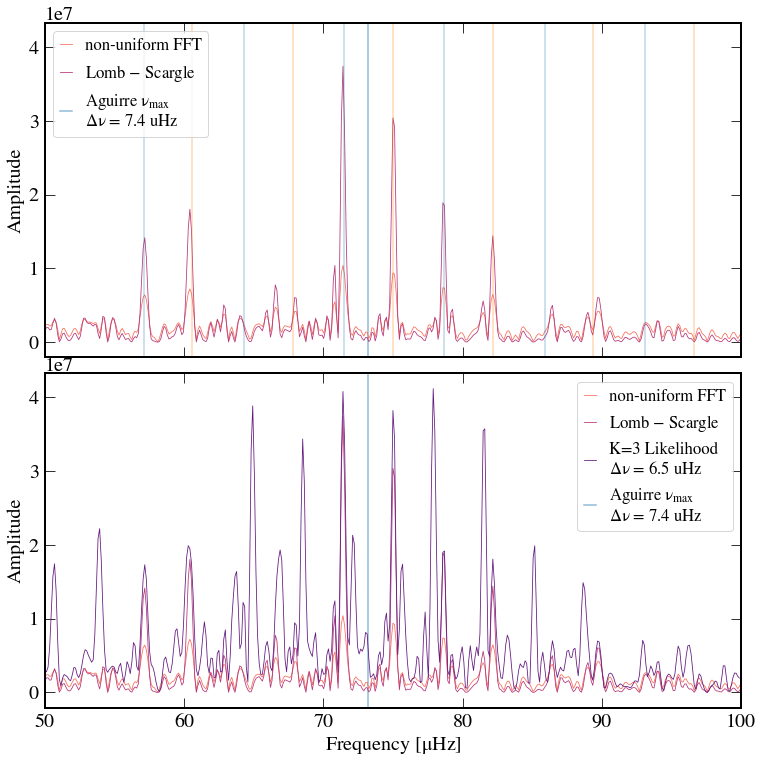

In [88]:
# compare the three spectral analyses of the light curve
cmap = mpl.cm.magma
iclose = 3

fig, ax = plt.subplots(2,1,figsize=(11,11), sharex=True, sharey=True)

for i in range(2):
    plt.sca(ax[i])
    plt.plot(k, amp*4*np.pi, '-', color=cmap(0.7), lw=0.8, label='non-uniform FFT')
    plt.plot(k[ind_positive], pgram, '-', color=cmap(0.5), lw=0.8, label='Lomb $-$ Scargle')
    if i==1:
        plt.plot(k[ind_xrange], (fll[iclose]-np.min(fll[iclose]))/(np.median(ivar)),
                 '-', color=cmap(0.3), lw=0.8,
             label='K={:d} Likelihood\n$\Delta\\nu$ = {:.1f}'.format(K0, dfreqs[iclose]))

    plt.axvline(tin['numax'][i0], label='Aguirre $\\nu_{{max}}$\n$\Delta\\nu$ = {:.1f} uHz'.format(tin['Delnu'][i0]),
                zorder=0, alpha=0.5)
    plt.ylabel('Amplitude')
    plt.legend(fontsize='small', handlelength=0.7)

plt.sca(ax[0])
for i in range(15):
    plt.axvline(71.5+(i-2)*7.2, color='tab:blue', alpha=0.3)
    plt.axvline(75.+(i-2)*7.2, color='tab:orange', alpha=0.3)

plt.sca(ax[1])
# plt.xlim(0,150)
plt.xlim(50,100)
# plt.ylim(0, 0.05)
plt.xlabel('Frequency [$\mu$Hz]')

plt.tight_layout(h_pad=0)

- tiny grid, find best -> visualize
- set numax, delta nu=7.2, plot nupeak
- visualize in data space, spectrum (lay down the freq, what are their amplitudes

- try filtering the data to this region of frequencies (low-, high-pass filters)

In [90]:
from scipy.signal import butter, filtfilt

In [173]:
# normal_cutoff = cutoff / nyq
# Get the filter coefficients 

fs = 0.5/(tm[1]-tm[0])
flow = (40*u.uHz).to(u.day**-1).value/fs
fhigh = (110*u.uHz).to(u.day**-1).value/fs
order = 9
print(fs, flow, fhigh, (fs*u.day**-1).to(u.uHz))

# for some reason this gives nans
# b, a = butter(order, [flow, fhigh], btype='band', analog=False)
# fm_band2 = filtfilt(b, a, fm)

b, a = butter(order, flow, btype='high', analog=False)
fm_band = filtfilt(b, a, fm)

b, a = butter(order, fhigh, btype='low', analog=False)
fm_band = filtfilt(b, a, fm_band)

359.9970707110765 0.00960007811500691 0.026400214816269002 4166.632762859682 uHz


In [176]:
b, a

(array([ 5.34307523e-15,  0.00000000e+00, -4.80876771e-14,  0.00000000e+00,
         1.92350708e-13,  0.00000000e+00, -4.48818319e-13,  0.00000000e+00,
         6.73227479e-13,  0.00000000e+00, -6.73227479e-13,  0.00000000e+00,
         4.48818319e-13,  0.00000000e+00, -1.92350708e-13,  0.00000000e+00,
         4.80876771e-14,  0.00000000e+00, -5.34307523e-15]),
 array([ 1.00000000e+00, -1.76739268e+01,  1.47531116e+02, -7.72832035e+02,
         2.84701829e+03, -7.83237164e+03,  1.66763699e+04, -2.80977798e+04,
         3.79780922e+04, -4.14877858e+04,  3.67166957e+04, -2.62623109e+04,
         1.50692982e+04, -6.84251084e+03,  2.40460273e+03, -6.31058005e+02,
         1.16465993e+02, -1.34890138e+01,  7.37868776e-01]))

In [177]:
fm_band

array([-31.91322108, -28.61684796, -25.28751949, ..., 526.09895326,
       526.13165931, 526.15753327])

In [168]:
# pgram = signal.lombscargle(tm, fm, freq, normalize=False)
pgram_band = signal.lombscargle(tm, fm_band, freq, normalize=False)

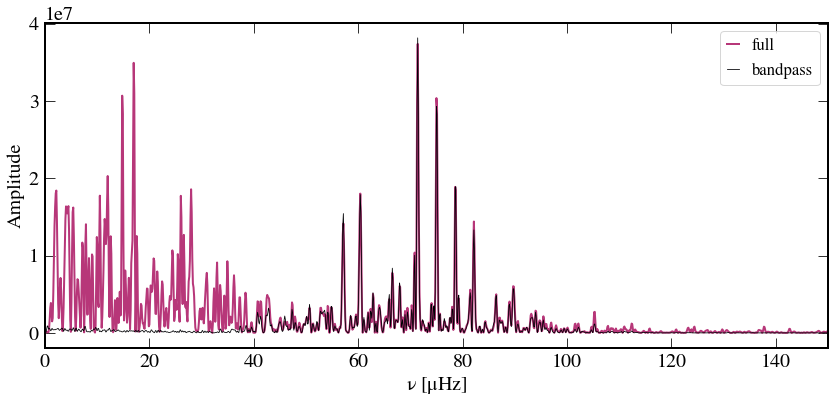

In [181]:
plt.figure(figsize=(12,6))
plt.plot(k[ind_positive], pgram, '-', color=cmap(0.5), lw=2, label='full')
plt.plot(k[ind_positive], pgram_band, '-', color=cmap(0), lw=0.8, label='bandpass')

plt.legend(fontsize='small', handlelength=0.7)
plt.xlabel('$\\nu$ [$\mu$Hz]')
plt.ylabel('Amplitude')

plt.xlim(0,150)
plt.tight_layout()
plt.savefig('../plots/powerspectrum_{:09d}.png'.format(tin['TIC'][i0]))

In [170]:
fll_band = np.empty((Ndfreq, np.size(freqs)))
for i in range(Ndfreq):
    fll_band[i] = np.array([ln_profile_like_K_freqs(tm, fm_band, ivar, f, dfreqs_iday[i], K=K0) for f in freqs_iday])

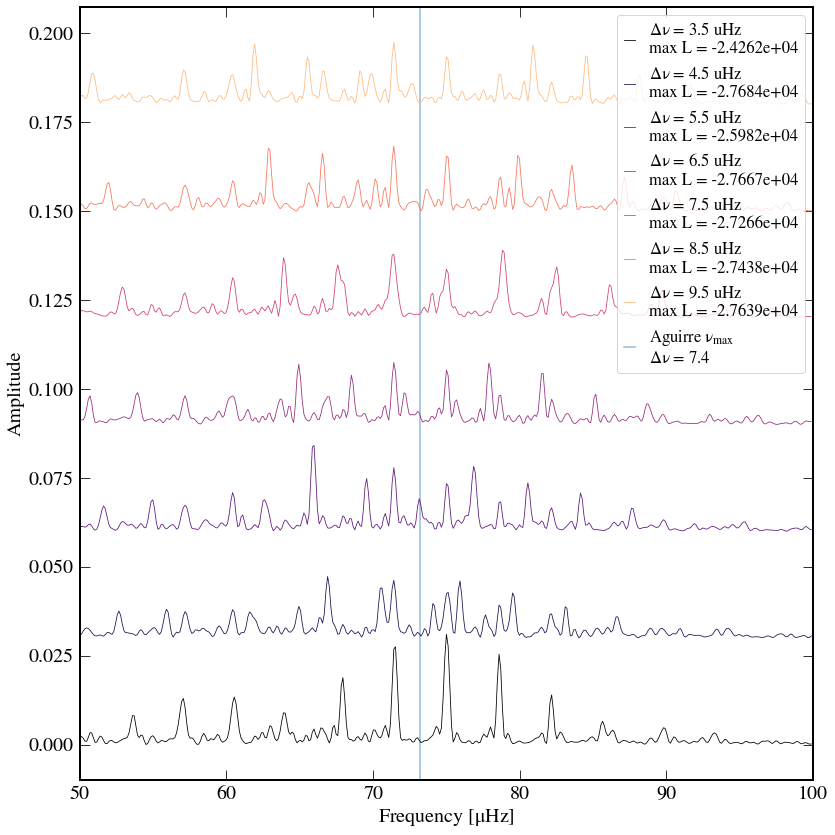

In [171]:
# compare forward models of the light curve assuming different Delta nu
cmap = mpl.cm.magma

plt.figure(figsize=(12,12))

for i in range(Ndfreq):
    plt.plot(k[ind_xrange], 0.03*i+(fll_band[i]-np.min(fll_band[i]))*4e-6, '-', color=cmap(i/Ndfreq), lw=0.8,
             label='$\Delta\\nu$ = {:.1f}\nmax L = {:.4e}'.format(dfreqs[i], np.max(fll_band[i])))
plt.axvline(tin['numax'][i0], label='Aguirre $\\nu_{{max}}$\n$\Delta\\nu$ = {:.1f}'.format(tin['Delnu'][i0]),
            zorder=0, alpha=0.5)

plt.legend(fontsize='small', handlelength=0.7)
plt.xlim(50,100)
# plt.ylim(0, 0.05)

plt.xlabel('Frequency [$\mu$Hz]')
plt.ylabel('Amplitude')

plt.tight_layout()